In [1]:
import nltk
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from collections import OrderedDict
import math
import re
import numpy as np 

In [2]:
#nltk.download()

In [3]:
def tokenization(text):
    tokens = []
    ExpReg = nltk.RegexpTokenizer('(?:[A-Za-z]\.)+|[A-Za-z]+[\-@]\d+(?:\.\d+)?|\d+[A-Za-z]+|\d+(?:[\.\,]\d+)?%?|\w+(?:[\-/]\w+)*')
    tokens = ExpReg.tokenize(text)
    return tokens

In [4]:
def stop_words(tokens):
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    tokens_without_stopwords = []
    tokens_without_stopwords = [word for word in tokens if word.lower() not in nltk_stopwords]
    return tokens_without_stopwords

In [5]:
def normalization_porter(tokens): #stemming
    Porter = nltk.PorterStemmer()
    normalized_words = []
    normalized_words = [Porter.stem(word) for word in tokens]
    return normalized_words

In [6]:
def normalization_lancaster(tokens): #stemming
    Lancaster = nltk.LancasterStemmer()
    normalized_words = []
    normalized_words = [Lancaster.stem(word) for word in tokens]
    return normalized_words

In [7]:
def extract_documents(file_path):
    documents = []
    current_document = {"number": None, "text": ""}
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith("Document"):
                
                if current_document["number"] is not None:
                    documents.append(current_document.copy())
                
                current_document["number"] = int(line.split()[1])
                current_document["text"] = ""
            elif line:
                
                current_document["text"] += line + '\n'
    

    if current_document["number"] is not None:
        documents.append(current_document.copy())
    
    return documents

In [8]:
from collections import defaultdict
def index(file_path, Inverse, Tokenize, PorterStemmer):
            word_file_count = defaultdict(set)
            unique_document_numbers = set() 
            d = {}
            dict = {}
            
            documents = extract_documents(file_path)

            for document in documents:
                file_id = document["number"]
                text = document["text"]
                unique_document_numbers.add(file_id)

                if Tokenize:
                    tokens = tokenization(text)
                else:
                    tokens = text.split()

                tokens_without_stopwords = stop_words(tokens)

                if PorterStemmer:
                    normalized_words = normalization_porter(tokens_without_stopwords)
                else:
                    normalized_words = normalization_lancaster(tokens_without_stopwords)

                words_frequency = nltk.FreqDist(normalized_words)


                for word in words_frequency.keys():
                    if Inverse:
                        if word in d:
                            d[word].append((file_id, words_frequency[word], max(list(words_frequency.values()))))
                        else:
                            d[word] = [(file_id, words_frequency[word], max(list(words_frequency.values())))]
                    else:
                        if file_id in d:
                            d[file_id].append((word, words_frequency[word], max(list(words_frequency.values()))))
                        else:
                            d[file_id] = [(word, words_frequency[word], max(list(words_frequency.values())))]
                        word_file_count[word].add(file_id)
                        
            for key1, values in d.items():
                for (key2, freq, max_freq) in values:
                        if Inverse:
                            value = (key2, freq, (freq / max_freq) * np.log10(((len(unique_document_numbers) / len(d[key1]))+1)))
                        else: 
                            value = (key2, freq, (freq / max_freq) * np.log10(((len(unique_document_numbers) / len(word_file_count[key2]))+1)))
                        if key1 in dict:
                            dict[key1].append(value)
                        else:
                            dict[key1] = [value]
                            
            return dict


In [9]:
def write_dict_to_file(dictionary, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        for key, values in dictionary.items():
            for value in values:
                (files_list, freq, weight) = value
                file.write(f"{key} {files_list} {freq} {weight:.5f}\n")

In [10]:
file_path = "LISA COLLECTION\\docs.txt"
dict = index(file_path, Inverse=True, Tokenize=True, PorterStemmer=True)
write_dict_to_file(dict, "InverseTokenPorter.txt")
        
print(dict)
print(len(dict))
print("*************************************************************")

{'indian': [(1, 4, 1.3511129522250125), (3, 1, 0.4053338856675038), (99, 1, 0.28952420404821694), (338, 3, 1.2160016570025112), (382, 1, 0.28952420404821694), (498, 1, 1.0133347141687594), (503, 2, 0.8106677713350076), (557, 1, 1.0133347141687594), (597, 2, 2.026669428337519), (606, 1, 1.0133347141687594), (626, 2, 1.3511129522250125), (632, 3, 2.026669428337519), (717, 1, 0.6755564761125062), (750, 1, 0.6755564761125062), (764, 1, 0.6755564761125062), (773, 4, 2.026669428337519), (835, 2, 1.3511129522250125), (872, 3, 1.0133347141687594), (1517, 2, 1.3511129522250125), (1586, 1, 0.5066673570843797), (1875, 1, 0.4053338856675038), (1950, 4, 2.026669428337519), (1974, 2, 1.3511129522250125), (2157, 3, 1.2160016570025112), (2206, 1, 0.4053338856675038), (2211, 1, 0.5066673570843797), (2260, 1, 0.4053338856675038), (2322, 2, 1.3511129522250125), (2510, 1, 0.1558976483336553), (2616, 3, 0.8685726121446509), (2796, 1, 0.5066673570843797), (2859, 4, 2.026669428337519), (2982, 2, 1.0133347141

# utils

In [11]:
def preprocess_query(query, Tokenize, PorterStemmer):
    if Tokenize:
        q = tokenization(query)
    else :
        q = query.split()
    if PorterStemmer:
        q = normalization_porter(q)
    else:
        q = normalization_lancaster(q)
    return q

# Vectorial Model

In [12]:
def scalar_product(query, file_path):
    terms_by_doc = {}
    with open(file_path, 'r') as file:
        for line in file:
            term, doc_id, freq, weight = line.split()
            if term in query:
                weight = float(weight) 

                if doc_id in terms_by_doc:
                    terms_by_doc[doc_id] += weight
                else:
                    terms_by_doc[doc_id] = weight

    terms_by_doc = sorted(terms_by_doc.items(), key=lambda x: x[1], reverse=True)

    return terms_by_doc

In [29]:
def cosine_measure(query, file_path):
    terms_by_doc = scalar_product(query, file_path)
    weight_by_doc = {}
    result_by_doc = {}
    sum_vi = len(query)

    with open(file_path, 'r') as file:
        for line in file:
            term, doc, freq, weight = line.split()
            weight = float(weight) 
  
            if doc in weight_by_doc:
                weight_by_doc[doc] += weight**2
            else:
                weight_by_doc[doc] = weight**2

    sum_vi = math.sqrt(sum_vi)
    
    for doc, sum_squared in weight_by_doc.items():
        weight_by_doc[doc] = math.sqrt(sum_squared)

    for (doc, terms) in terms_by_doc:
        result_by_doc[doc] = terms / (sum_vi * weight_by_doc[doc])

    result_by_doc= sorted(result_by_doc.items(), key=lambda x: x[1], reverse=True)

    return result_by_doc

In [30]:
def jaccard_measure(query, file_path):
    terms_by_doc = scalar_product(query, file_path)
    weight_by_doc = {}
    result_by_doc = {}
    sum_vi = len(query)

    with open(file_path, 'r') as file:
        for line in file:
            term, doc, freq, weight = line.split()
            weight = float(weight)  
  
            if doc in weight_by_doc:
                weight_by_doc[doc] += weight**2
            else:
                weight_by_doc[doc] = weight**2

    for (doc, terms) in terms_by_doc:
        result_by_doc[doc] = terms / (sum_vi + weight_by_doc[doc] - terms)

    result_by_doc= sorted(result_by_doc.items(), key=lambda x: x[1], reverse=True)

    return result_by_doc

In [31]:
def file(Tokenize, PorterStemmer):
    if Tokenize:
        if PorterStemmer:
            return "InverseTokenPorter.txt"
        else:
            return "InverseTokenLancaster.txt"
    else:
        if PorterStemmer:
            return "InverseSplitPorter.txt"
        else:
            return "InverseSplitLancaster.txt"

In [32]:
def vectorial_model(query, Tokenize, PorterStemmer, SP, cosine, jaccard):
        query = preprocess_query(query, Tokenize, PorterStemmer)
        file_path = file(Tokenize, PorterStemmer)
        if SP:
            result = scalar_product(query, file_path)
        else: 
            if cosine:
                result = cosine_measure(query, file_path)
            else:
                if jaccard:
                    result = jaccard_measure(query, file_path)

        return result

# Probabilistic Model

In [33]:
def n_docs_terms(file_path, query):
    documents_containing_terms = {}

    with open(file_path, 'r') as file:
        for line in file:
            current_term, _, _, _ = line.strip().split()

            if current_term in query:
                if current_term not in documents_containing_terms:
                    documents_containing_terms[current_term] = 1
                else:
                    documents_containing_terms[current_term] += 1
            elif len(documents_containing_terms) == len(query):
                # If we have encountered all terms and the next one is different, stop the loop
                break
    return documents_containing_terms

In [34]:
def BM25(query, file_path, K, B):
    dl = {}
    result = {}
    vocab_len = 0

    with open(file_path, 'r') as file:
        for line in file:
            _, doc_id, freq, _ = line.strip().split()
            dl[doc_id] = dl.get(doc_id, 0) + int(freq)
            vocab_len += int(freq)

    N = len(dl)
    avdl = vocab_len / N
    ni = n_docs_terms(file_path, query)

    with open(file_path, 'r') as file:
        for line in file:
            term, doc, freq, _ = line.split()
            freq = int(freq)
            if term in query:
                if doc in result:
                    result[doc] += ((freq / (K * ((1 - B) + B * (dl[doc] / avdl)) + freq)) * np.log10(((N - ni[term] + 0.5) / (ni[term] + 0.5))))
                else:
                    result[doc] = ((freq / (K * ((1 - B) + B * (dl[doc] / avdl)) + freq)) * np.log10(((N - ni[term] + 0.5) / (ni[term] + 0.5))))
                    
    result = sorted(result.items(), key=lambda x: x[1], reverse=True)

    return result

In [35]:
def probabilistic_model(query, Tokenize, PorterStemmer, K, B):
    query = preprocess_query(query, Tokenize, PorterStemmer)
    file_path = file(Tokenize, PorterStemmer)
    result = BM25(query, file_path, K, B)
        
    return result

# Boolean Model

In [36]:
def boolean_query(query):
    
    if isinstance(query, list):
        query = ' '.join(query)

    # reg expresssion 
    reg_exp = r'\b(?:((?:[A-Za-z]\.)+|[A-Za-z]+[\-@]\d+(?:\.\d+)?|\d+[A-Za-z]+|\d+(?:[\.\,]\d+)?%?|\w+(?:[\-/]\w+)*)\b|and|or|not)\b'

    matches = re.findall(reg_exp, query)

    if not is_valid_boolean_query(matches):
        print("ERROR : Invalid query !")
        return None
    return matches

def is_valid_boolean_query(matches):
    if not matches:
        return False

    operators = {'and', 'or', 'not'}
    for match in matches:
        if match not in operators and not re.match(r'\b\w+\b', match):
            return False
    
    # operator order
    if matches[0] in operators-{'not'} or matches[-1] in operators:
        return False
    
    # NOT & term term 
    for i in range(len(matches) - 1):
        if matches[i] == 'not' and ((not matches[i + 1]) or (matches[i+1] in operators)):
            return False
        if  matches[i] not in operators and matches[i+1] not in operators:
            print(matches[i])
            return False
        
    #  AND OR / OR AND
    for i in range(len(matches) - 2):
        if matches[i] in operators-{'not'} and matches[i + 1] in operators-{'not'}:
            return False
        
    return True


In [37]:
def boolean_query_evaluation(query, file_path):
    terms_and_operators = boolean_query(query)
    
    if terms_and_operators is None:
        return None
    else:
        result_set = set()

        with open(file_path, 'r') as file:
            lines = file.readlines()
            operator_stack = []

            for token in terms_and_operators:
                if token == 'not':
                    operator_stack.append('not')
                elif token == 'and':
                    operator_stack.append('and')
                elif token == 'or':
                    operator_stack.append('or')
                else:
                    term_results = set()
                    
                    for line in lines:
                        term, doc, _, _ = line.strip().split()
                        doc = int(doc)

                        if term == token:
                            term_results.add(doc)

                    if 'not' in operator_stack:
                        term_results = set() - term_results
                        operator_stack.remove('not')
                    if 'and' in operator_stack:
                        result_set = result_set.intersection(term_results)
                        operator_stack.remove('and')
                    elif 'or' in operator_stack:
                        result_set = result_set.union(term_results)
                        operator_stack.remove('or')
                    else:
                        result_set = term_results

        return result_set

In [38]:
def boolean_model(query, Tokenize, PorterStemmer):
    query = preprocess_query(query, Tokenize, PorterStemmer)
    file_path = file(Tokenize, PorterStemmer)

    result_dict = {}
    results = boolean_query_evaluation(query, file_path)
    
    if results is not None:
        for doc in results:
            result_dict[doc] = 'YES'
    else:
        result_dict = None

    return result_dict

# Test

In [39]:
query = "Documents ranking"
res = probabilistic_model(query, Tokenize=True, PorterStemmer=True, K=1.50, B=0.75)
res2 = vectorial_model(query, Tokenize=True, PorterStemmer=True, SP=True, cosine=False, jaccard=False)
res3 = boolean_model(query, Tokenize=True, PorterStemmer=True)
print(res2)
print(res)
print(res3)


document
ERROR : Invalid query !
[('3374', 2.08225), ('5087', 1.57549), ('1830', 1.40044), ('5165', 1.40044), ('118', 1.05033), ('139', 1.05033), ('1624', 1.05033), ('5135', 1.05033), ('5681', 1.05033), ('638', 1.04419), ('4448', 1.04419), ('2144', 1.0411199999999998), ('459', 1.03192), ('582', 1.03192), ('594', 1.03192), ('639', 1.03192), ('771', 1.03192), ('777', 1.03192), ('818', 1.03192), ('948', 1.03192), ('1210', 1.03192), ('1258', 1.03192), ('1272', 1.03192), ('1280', 1.03192), ('1321', 1.03192), ('1324', 1.03192), ('1409', 1.03192), ('1807', 1.03192), ('1814', 1.03192), ('1860', 1.03192), ('2206', 1.03192), ('2344', 1.03192), ('2445', 1.03192), ('2520', 1.03192), ('2663', 1.03192), ('2852', 1.03192), ('2858', 1.03192), ('2949', 1.03192), ('3036', 1.03192), ('3121', 1.03192), ('3229', 1.03192), ('3262', 1.03192), ('3484', 1.03192), ('3494', 1.03192), ('3525', 1.03192), ('3534', 1.03192), ('3557', 1.03192), ('3667', 1.03192), ('3891', 1.03192), ('3967', 1.03192), ('3968', 1.03192

# Metrics

In [40]:
def precision(relevant_docs, retrieved_docs, cutoff=None):
    total_retrieved = len(retrieved_docs[:cutoff])
    if total_retrieved == 0:
        return 0
    if cutoff == None:
        cutoff = total_retrieved
    relevant_retrieved = len(set(relevant_docs) & set(retrieved_docs[:cutoff]))
    return relevant_retrieved / cutoff

def recall(relevant_docs, retrieved_docs, cutoff=None):
    total_relevant = len(relevant_docs)
    if total_relevant == 0:
        return 0
    relevant_retrieved = len(set(relevant_docs) & set(retrieved_docs[:cutoff]))
    return relevant_retrieved / total_relevant

def f_score(precision_value, recall_value):
    if precision_value + recall_value > 0:
        return 2 * (precision_value * recall_value) / (precision_value + recall_value)
    else:
        return 0

In [41]:
with open('Queries.txt', 'r') as queries_file:
    queries = [line.strip() for line in queries_file]

with open('Judgements.txt', 'r') as judgments_file:
    judgments = [tuple(map(int, line.strip().split())) for line in judgments_file]

In [42]:
for i, query in enumerate(queries, start=1):
    dict = vectorial_model(query, Tokenize=True, PorterStemmer=True, SP=True, cosine=False, jaccard=False)
    relevant_docs = [doc_id for (q_id, doc_id) in judgments if q_id == i]
    selected_docs = [int(tup[0]) for tup in dict]
    selected_relevant_docs = [doc for doc in relevant_docs if doc in selected_docs]
    # Metrics evaluation
    precision_value = precision(selected_relevant_docs, selected_docs)
    precision_5 = precision(selected_relevant_docs, selected_docs, 5)
    precision_10 = precision(selected_relevant_docs, selected_docs, 10)
    recall_value = recall(selected_relevant_docs, selected_docs)
    f_score_value = f_score(precision_value, recall_value) 
    
    print(f"Query {i} Metrics:")
    print(f"Precision: {precision_value}")
    print(f"P@5: {precision_5}")
    print(f"P@10: {precision_10}")
    print(f"Recall: {recall_value}")
    print(f"F-Score: {f_score_value}")
    print()

Query 1 Metrics:
Precision: 0.0003168567807351077
P@5: 0.0
P@10: 0.0
Recall: 1.0
F-Score: 0.0006335128286347799



Query 2 Metrics:
Precision: 0.0
P@5: 0.0
P@10: 0.0
Recall: 0
F-Score: 0



In [43]:
import matplotlib.pyplot as plt

def interpolate_precision(precision_values, recall_values, recall_levels):
    interpolated_precisions = []
    for level in recall_levels:
        max_precision = 0
        for i in range(len(recall_values)):
            if recall_values[i] >= level:
                max_precision = max(max_precision, precision_values[i])
        interpolated_precisions.append(max_precision)
    return interpolated_precisions

def plot_precision_recall_curve(relevant_docs, retrieved_docs, model_name):
    recall_levels = [i / 10 for i in range(11)]
    
    # Calculate precision at each recall level
    precision_values = [precision(relevant_docs, retrieved_docs, cutoff=int(len(retrieved_docs) * level)) for level in recall_levels]
    
    # Calculate interpolated precisions
    interpolated_precisions = interpolate_precision(precision_values, recall_levels, recall_levels)

    plt.plot(recall_levels, interpolated_precisions, marker='o', linestyle='-', label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

relevant_docs are : [1, 3, 4]
selected_docs are : [4353, 1872, 3814, 3346, 2882, 3893, 3657, 3397, 3447, 934, 1992, 1399, 435, 6001, 2909, 3389, 3398, 3405, 4755, 3777, 394, 5918, 3401, 3977, 399, 434, 1903, 3033, 3388, 3894, 5939, 2820, 2903, 392, 998, 3107, 3451, 2945, 1210, 2748, 3560, 3392, 863, 2319, 391, 2789, 3407, 3667, 4036, 3971, 878, 1789, 3903, 4271, 3966, 3194, 2905, 2894, 2422, 514, 5383, 752, 3393, 389, 2408, 3400, 1997, 139, 799, 1317, 2194, 2534, 2851, 3638, 3833, 5848, 6003, 4007, 4459, 5691, 3452, 2933, 532, 3926, 1909, 3262, 1324, 2914, 2987, 3445, 3869, 5340, 112, 439, 835, 1067, 2406, 3491, 3902, 4269, 5351, 2054, 5513, 2761, 3369, 1426, 1235, 5394, 2790, 879, 3915, 4364, 484, 4363, 4253, 5835, 1609, 888, 1973, 2002, 4799, 5509, 5126, 2712, 4701, 2900, 2099, 2772, 3224, 5370, 1405, 1722, 1891, 2236, 2290, 2908, 4351, 2745, 4854, 4215, 3032, 350, 4899, 3300, 5816, 4674, 1590, 1782, 3227, 4990, 1864, 738, 2943, 2944, 4919, 3218, 2313, 3790, 5772, 638, 4279, 4284, 44

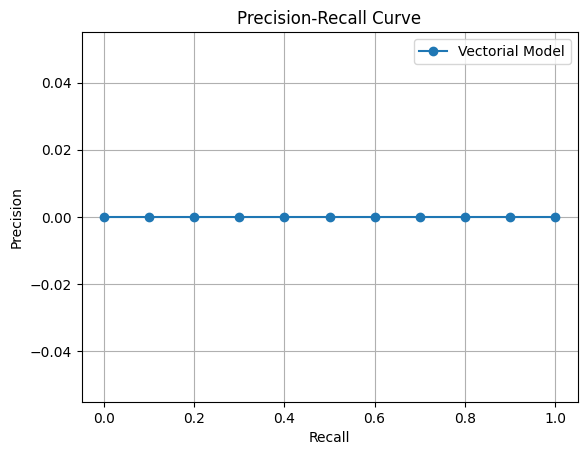

In [44]:
for i, query in enumerate(queries, start=1):
    dict = vectorial_model(query, Tokenize=True, PorterStemmer=True, SP=True, cosine=False, jaccard=False)
    relevant_docs = [doc_id for (q_id, doc_id) in judgments if q_id == i]
    selected_docs = [int(tup[0]) for tup in dict]
    selected_relevant_docs = [doc for doc in relevant_docs if doc in selected_docs]
    print(f"relevant_docs are : {relevant_docs}")
    print(f"selected_docs are : {selected_docs}")
    print(f"selected_relevant_docs are : {selected_relevant_docs}")

plot_precision_recall_curve(selected_relevant_docs, selected_docs, "Vectorial Model")